In [1]:
import cv2
import numpy as np
import pandas as pd
filename = 'E:/pythonfile/recognition/handwritten_numbers/hw_numbers_dataset/'
data = pd.read_csv( filename + 'annotation.csv')


In [2]:

x_data = [] #handwritten numbers dataset
for i in range(len(data)):
    img_dir = filename+data.loc[i, 'FileName']+'.jpg'
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = image/255.
    x_data.append(image)


In [3]:
x_data = np.array(x_data).reshape(-1, 32, 64, 1)

In [4]:
train_x =x_data[:60000]
test_x= x_data[60000:80000]
valid_x= x_data[80000:]

In [5]:
train_size = 60000
test_size= 20000
valid_size= 20000

In [6]:
for i in range(len(data)):
    data.loc[i,'Value'] = str(data.loc[i,'Value']).replace(".", "")

In [7]:
str_len = []
for i in range(len(data)):
    str_len.append(len(data.loc[i,'Value']))

In [8]:
alphabets = u"0123456789-"
max_str_len = max(str_len) # max length of input labels 5
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 16 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [9]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * num_of_timestamps
train_output = np.zeros([train_size])

for i in data.index[:train_size]:
    train_label_len[i] = len(data.loc[i, 'Value'])
    train_y[i, 0:len(data.loc[i, 'Value'])]= label_to_num(data.loc[i, 'Value'])
print('True label : ',data.loc[100, 'Value'] , '\ntrain_y : ',train_y[100],
      '\ntrain_label_len : ',train_label_len[100],'\ntrain_input_len : ',train_input_len[100]) 

True label :  2549 
train_y :  [ 2.  5.  4.  9. -1.] 
train_label_len :  [4.] 
train_input_len :  [16.]


In [10]:
test_y = np.ones([test_size, max_str_len]) * -1
test_label_len = np.zeros([test_size, 1])
test_input_len = np.ones([test_size, 1]) * num_of_timestamps
test_output = np.zeros([test_size])

for i in data.index[train_size:train_size+test_size]:
    test_label_len[i-60000] = len(data.loc[i, 'Value'])
    test_y[i-60000, 0:len(data.loc[i, 'Value'])]= label_to_num(data.loc[i, 'Value']) 
print('True label : ',data.loc[60100, 'Value'] , '\ntrain_y : ',test_y[100],
      '\ntrain_label_len : ',test_label_len[100],'\ntrain_input_len : ',test_input_len[100]) 

True label :  1939 
train_y :  [ 1.  9.  3.  9. -1.] 
train_label_len :  [4.] 
train_input_len :  [16.]


In [11]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * num_of_timestamps
valid_output = np.zeros([valid_size])

for i in data.index[train_size+test_size:]:
    valid_label_len[i-80000] = len(data.loc[i, 'Value'])
    valid_y[i-80000, 0:len(data.loc[i, 'Value'])]= label_to_num(data.loc[i, 'Value']) 
print('True label : ',data.loc[80100, 'Value'] , '\ntrain_y : ',valid_y[100],
      '\ntrain_label_len : ',valid_label_len[100],'\ntrain_input_len : ',valid_input_len[100]) 

True label :  -630 
train_y :  [10.  6.  3.  0. -1.] 
train_label_len :  [4.] 
train_input_len :  [16.]


Label:1478


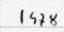

Label:198


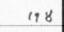

Label:648


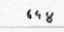

Label:3581


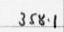

Label:392


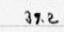

Label:1819


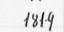

Label:3097


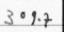

Label:-724


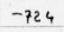

Label:475


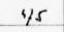

Label:419


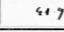

In [12]:
from PIL import Image
from IPython.display import display

def image_see(n):
    image_data = (np.squeeze(x_data[n]) * 255).astype('uint8')
    image = Image.fromarray(image_data, 'L')
    title = f"Label:{data.loc[n,'Value']}"
    print(title)
    display(image)
for id_n in np.random.randint(0, len(data),10):
    image_see(id_n)


In [15]:
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

input_data = Input(shape=(32, 64, 1), name='input')

inner = Conv2D(32, (3, 3), activation='elu', padding='same')(input_data)  
inner = Activation('elu')(inner)
inner = BatchNormalization()(inner)
'''
inner = Conv2D(32, (3, 3), activation='elu', padding='same')(input_data)  
inner = Activation('elu')(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), activation='elu', padding='same')(input_data)  
inner = Activation('elu')(inner)
inner = BatchNormalization()(inner)
'''

inner = Conv2D(64, (3, 3), activation='elu', padding='same')(inner)
inner = Activation('elu')(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), activation='elu', padding='same')(input_data)  
inner = Activation('elu')(inner)
inner = BatchNormalization()(inner)
inner = Conv2D(128, (3, 3), activation='elu', padding='same')(inner)
inner = Activation('elu')(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((16,128*64)), name='reshape')(inner)
inner = Dense(64, activation="softmax", name='dense1')(inner)
## RNN
inner = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters,name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 32, 64, 1)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 64, 128)       1280      
_________________________________________________________________
activation_10 (Activation)   (None, 32, 64, 128)       0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 64, 128)       512       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 64, 128)       147584    
_________________________________________________________________
activation_11 (Activation)   (None, 32, 64, 128)       0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 32, 64, 128)      

In [16]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    #y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [17]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [18]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
from tensorflow import keras
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy'])


history = model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([test_x, test_y, test_input_len, test_label_len], test_output),
                epochs=150, verbose=1, batch_size=400)

Epoch 1/150
150/150 [==============================] - 1225s 8s/step - loss: 10.6629 - accuracy: 0.0000e+00 - val_loss: 12.9363 - val_accuracy: 0.0000e+00
Epoch 2/150
150/150 [==============================] - 1179s 8s/step - loss: 9.3364 - accuracy: 0.0000e+00 - val_loss: 9.0551 - val_accuracy: 0.0000e+00
Epoch 3/150
150/150 [==============================] - 1169s 8s/step - loss: 8.9643 - accuracy: 0.0000e+00 - val_loss: 9.4280 - val_accuracy: 0.0000e+00
Epoch 4/150
150/150 [==============================] - 1174s 8s/step - loss: 8.8066 - accuracy: 0.0000e+00 - val_loss: 8.6675 - val_accuracy: 0.0000e+00
Epoch 5/150
150/150 [==============================] - 1173s 8s/step - loss: 8.5883 - accuracy: 0.0000e+00 - val_loss: 8.7821 - val_accuracy: 0.0000e+00
Epoch 6/150
150/150 [==============================] - 1174s 8s/step - loss: 8.1288 - accuracy: 0.0000e+00 - val_loss: 8.3993 - val_accuracy: 0.0000e+00
Epoch 7/150
150/150 [==============================] - 1174s 8s/step - loss: 7.7

In [19]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2, subplot_titles=("Model accuracy", "Model loss"))

# Add the first subplot for accuracy
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['accuracy']) + 1)),
                         y=history.history['accuracy'], mode='lines',
                         name='Train', line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_accuracy']) + 1)),
                         y=history.history['val_accuracy'], mode='lines',
                         name='Validation', line=dict(color='orange')), row=1, col=1)

# Add the second subplot for loss
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['loss']) + 1)),
                         y=history.history['loss'], mode='lines',
                         name='Train', line=dict(color='blue'), showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_loss']) + 1)),
                         y=history.history['val_loss'], mode='lines',
                         name='Validation', line=dict(color='orange'), showlegend=False), row=1, col=2)

fig.update_layout(title="Model Training History",
                  xaxis_title="Epoch",
                  yaxis_title="Value",
                  legend=dict(x=0.85, y=1))

fig.show()

In [20]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [21]:
y_true = []
for i in range(20000):
    y_true.append(str(data.loc[i+80000, 'Value']))

In [22]:
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 86.17%
Correct words predicted      : 67.41%


Label:540; Predicted:540


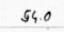

Label:456; Predicted:456


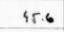

Label:570; Predicted:570


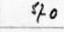

Label:2823; Predicted:2822


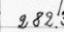

Label:811; Predicted:811


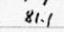

Label:243; Predicted:2293


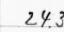

Label:2511; Predicted:2511


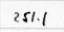

Label:425; Predicted:425


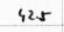

Label:-107; Predicted:-107


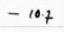

Label:2868; Predicted:2865


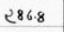

In [23]:
for id_n in np.random.randint(0, len(y_true),10):
    image_data = (np.squeeze(valid_x[id_n]) * 255).astype('uint8')
    image = Image.fromarray(image_data, 'L')
    title = f"Label:{y_true[id_n]}; Predicted:{prediction[id_n]}"
    print(title)
    display(image)

